In [4]:
#Import#

from cellpose import models, core, io, plot
import numpy as np
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from cellpose import train
from cellpose import metrics
import imageio.v2 as imageio
import os
import skimage.filters
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage import data, img_as_float
import pandas as pd
from glob import glob

In [5]:
#Data input from the User

folder_path = r'Y:\Group Members\Valentin Aubry\01_Data\Test_Data_Andreas_small_diverse'  # The r in r'Example' is very important

In [6]:
# High Throughput Data Loading
Cy5_data = glob(os.path.join(folder_path, '*Cy5 SEM.tif'))
DAPI_data = glob(os.path.join(folder_path, '*DAPI SEM.tif'))
DAPI_mask_data = glob(os.path.join(folder_path, '*DAPI SEM_seg.npy'))
FITC_data = glob(os.path.join(folder_path, '*FITC SEM.tif'))
TRITC_data = glob(os.path.join(folder_path, '*TRITC SEM.tif'))


# Sorting the data in case it isn't yet
Cy5_data.sort()
DAPI_data.sort()
DAPI_mask_data.sort()
FITC_data.sort()
TRITC_data.sort()


# Displaying all the data that was loaded
print(os.path.basename(Cy5_data[i]))
print(os.path.basename(DAPI_data[i]))
print(os.path.basename(DAPI_mask_data[i]))
print(os.path.basename(FITC_data[i]))
print(os.path.basename(TRITC_data[i]))

# Loading DAPI picture and generated mask

Test_DAPI = imageio.imread(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--DAPI SEM.tif')
Test_TRITC = imageio.imread(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM.tif')
Testmask = np.load(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--DAPI SEM_seg.npy', allow_pickle=True).item()



In [8]:
#High Throughput Data Loading Loop
for i in range (len(DAPI_data)):
    #Loading the picture on i position from each channel
    Cy5_pic = imageio.imread(Cy5_data[i])
    DAPI_pic = imageio.imread(DAPI_data[i])
    DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
    FITC_pic = imageio.imread(FITC_data[i])
    TRITC_pic = imageio.imread(TRITC_data[i])

    # Extract the actual mask array
    masks = DAPI_mask_pic['masks']  # This contains the segmented regions

    # Function to generate a picture for every cell that cellpose recognized
    for i in range (1,len(np.unique(masks))):
        
        # Defining which nucleus from the Segmentation Mask is isolated
        cellnumber = i
        masks_reduced = (masks == cellnumber)  
    
        # Overlaying DAPI mask to TRITC
        masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  
    
        # Applying the mask to the TRITC picture by setting the background to 0 (black)
        isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
        isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)
        


In [6]:
# Extract the actual mask array
masks = Testmask['masks']  # This contains the segmented regions

# Generate a Folder to save all the pictures in
#os.makedirs(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM')

# Function to generate a picture for every cell that cellpose recognized
for i in range (1,len(np.unique(masks))):
    
    # Defining which nucleus from the Segmentation Mask is isolated
    cellnumber = i
    masks_reduced = (masks == cellnumber)  

    # Overlaying DAPI mask to TRITC
    masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  

    # Applying the mask to the TRITC picture by setting the background to 0 (black)
    isolated_TRITC = Test_TRITC.copy()  # copying the original picture so that it doesn't get changed
    isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)

    # Save the isolated TRITC image
    #imageio.imwrite(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM\UT_UT--W00014--P00001--Z00000--T00000--TRITC--'+str(cellnumber)+' SEM.tif', isolated_TRITC)

In [25]:
# loading the image with a specific cell isolated from the TRITC channel

cellnumber = 3
Isolated_TRITC = imageio.imread(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM\UT_UT--W00014--P00001--Z00000--T00000--TRITC--'+str(cellnumber)+' SEM.tif')


# Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
filtered_testimage = skimage.filters.difference_of_gaussians(Isolated_TRITC, 1, high_sigma=None, mode='nearest', cval=0, channel_axis=None, truncate=4.0)

# Saving the filtered file
imageio.imwrite(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM\UT_UT--W00014--P00001--Z00000--T00000--TRITC--'+str(cellnumber)+'--filtered SEM.tif', filtered_testimage)


# Detecting peaks in the filtered image
# conversion of integer pixel values to float
filt_img_float = img_as_float(filtered_testimage)

# Expanding the peaks to make them more visible
image_max = ndi.maximum_filter(filt_img_float, size=3, mode='constant') # moves over the picture with a square (size can be defined) and sets the middle of the square to the highest detected value inside the square

# Detecting the coordinates of the peaks
coordinates = peak_local_max(
    filt_img_float, 
    min_distance=2,
    threshold_rel=0.25      # Only peaks above 50% of maximum
    # OR
    #threshold_abs=0.2       # Adjust based on your image values
)


# Saving the filtered file
#imageio.imwrite(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM\UT_UT--W00014--P00001--Z00000--T00000--TRITC--'+str(cellnumber)+'--filtered SEM.tif', filtered_testimage)


In [19]:
#Creating a .csv file containing all the coordinates of foci labbeled with each cell
foci_data = pd.DataFrame(data=coordinates, columns=['y', 'x'])
foci_data['cell_number'] = cellnumber


#To create a .csv file with headers
foci_data.to_csv(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM.csv', index=False)


#To add to an existing .csv file without adding headers
foci_data.to_csv(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC SEM.csv', mode='a', header=False, index=False)

In [20]:
print(foci_data)

    y     x  cell_number
0  62  1043            3
1  74   995            3
2  54  1011            3
3  70  1008            3
4  57   987            3
5  42  1008            3


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

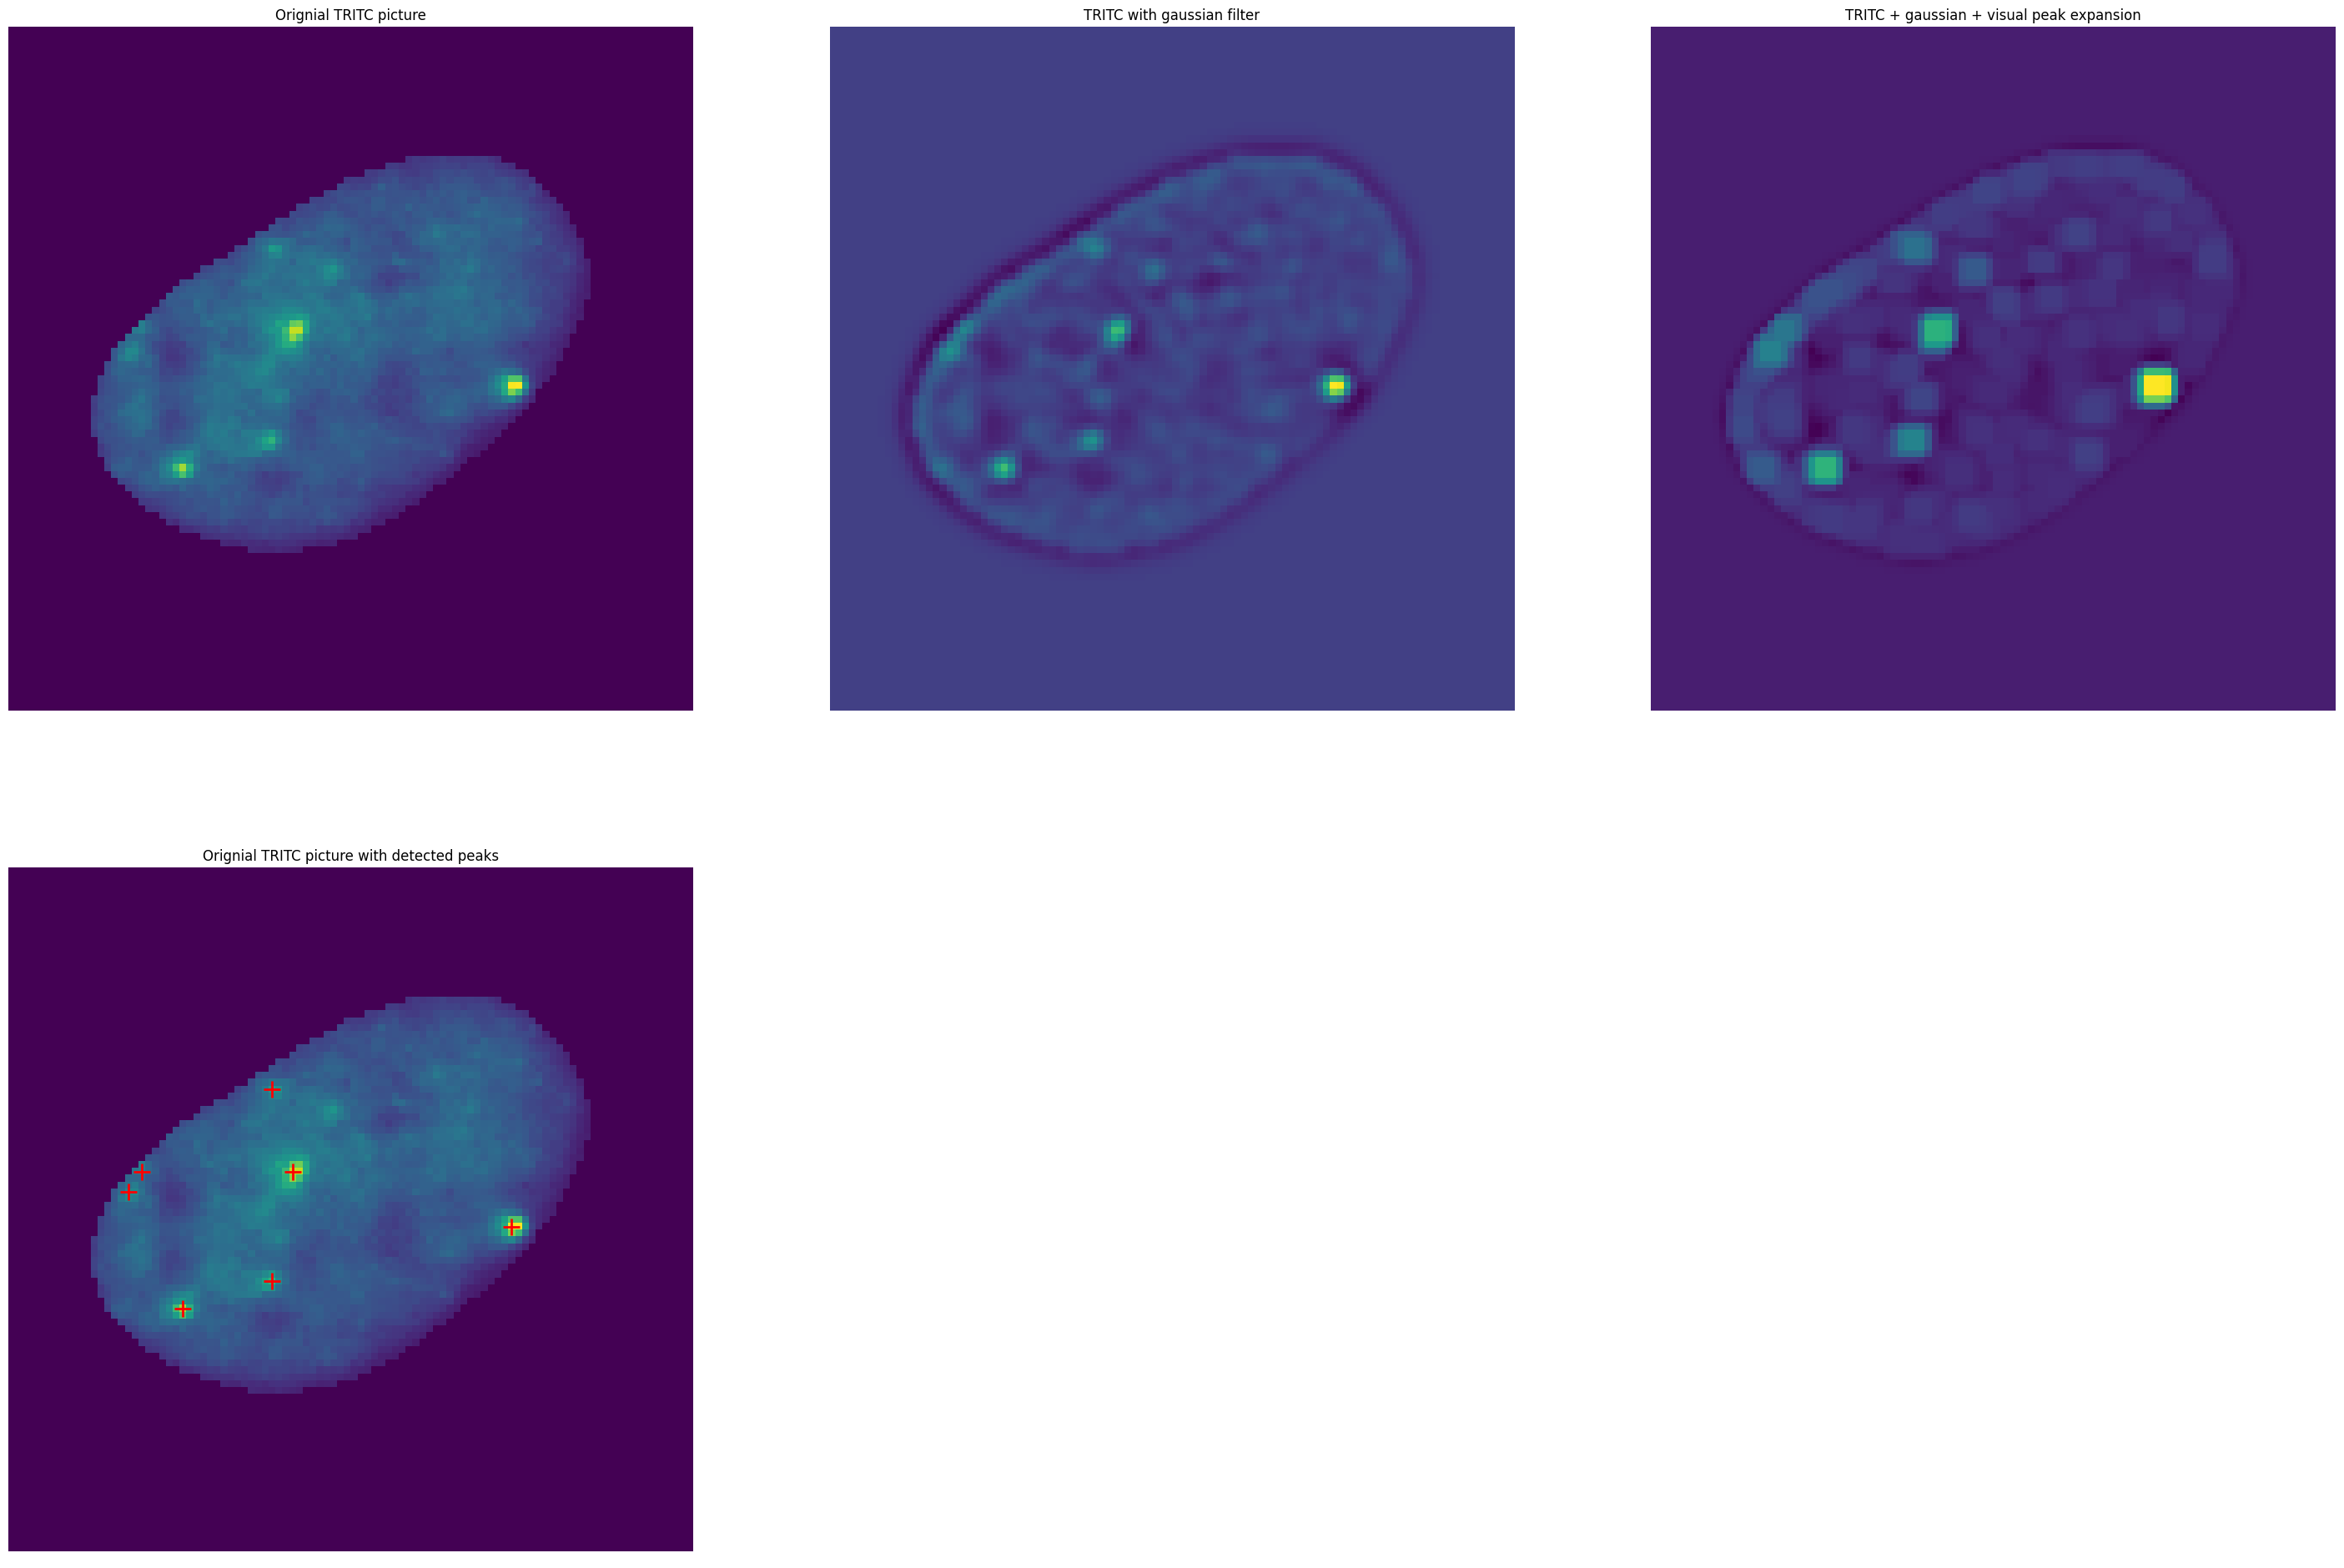

In [26]:
# Displaying the original picture with an isolated cell and the filtered picture
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36, 24))

# Initial crop
origin = (10,970)
size = (100,100)


# Original TRITC Picture with isolated cell
axes[0,0].imshow(Isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])
axes[0,0].axis('off')
axes[0,0].set_title('Orignial TRITC picture')

# Filtered TRITC picture with isolated cell
axes[0,1].imshow(filtered_testimage[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]]) 
axes[0,1].axis('off')
axes[0,1].set_title('TRITC with gaussian filter')

# Filtered TRITC picture with isolated cell
axes[0,2].imshow(image_max[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]]) 
axes[0,2].axis('off')
axes[0,2].set_title('TRITC + gaussian + visual peak expansion')


# Original TRITC Picture with isolated cell
axes[1,0].imshow(Isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])

##################################################################
# Adjust coordinates relative to the cropped region
adjusted_coords = coordinates - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_coords[:, 0] >= 0) & (adjusted_coords[:, 0] < size[0]) & \
       (adjusted_coords[:, 1] >= 0) & (adjusted_coords[:, 1] < size[1])
visible_coords = adjusted_coords[mask]

# Plot the peaks
axes[1,0].plot(visible_coords[:, 1], visible_coords[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[1,0].axis('off')
axes[1,0].set_title('Orignial TRITC picture with detected peaks')

axes[1,1].axis('off')

axes[1,2].axis('off')

In [37]:
print(f"Number of peaks detected: {len(coordinates)}")
print("First few coordinates:", coordinates[:7])


Number of peaks detected: 7
First few coordinates: [[  62 1043]
 [  74  995]
 [  54 1011]
 [  70 1008]
 [  57  987]
 [  54  989]
 [  42 1008]]


In [7]:
# Extract the actual mask array
masks = Testmask['masks']  # This contains the segmented regions

# Defining which nucleus from the Segmentation Mask is isolated
cellnumber = 60
masks_reduced = masks == cellnumber

# Overlaying DAPI mask to TRITC
masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced) # 

# Applying the mask to the TRITC picture by setting the background to 0 (black)
isolated_TRITC = Test_TRITC.copy()  # copying the original picture so that it doesn't get changed
isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)

# Save the isolated TRITC image
#imageio.imwrite(r'Y:\Group Members\Valentin Aubry\01_Data\Test_DATA_Andreas_verysmall_DAPI\UT_UT--W00014--P00001--Z00000--T00000--TRITC--'+str(cellnumber)+' SEM.tif', isolated_TRITC)


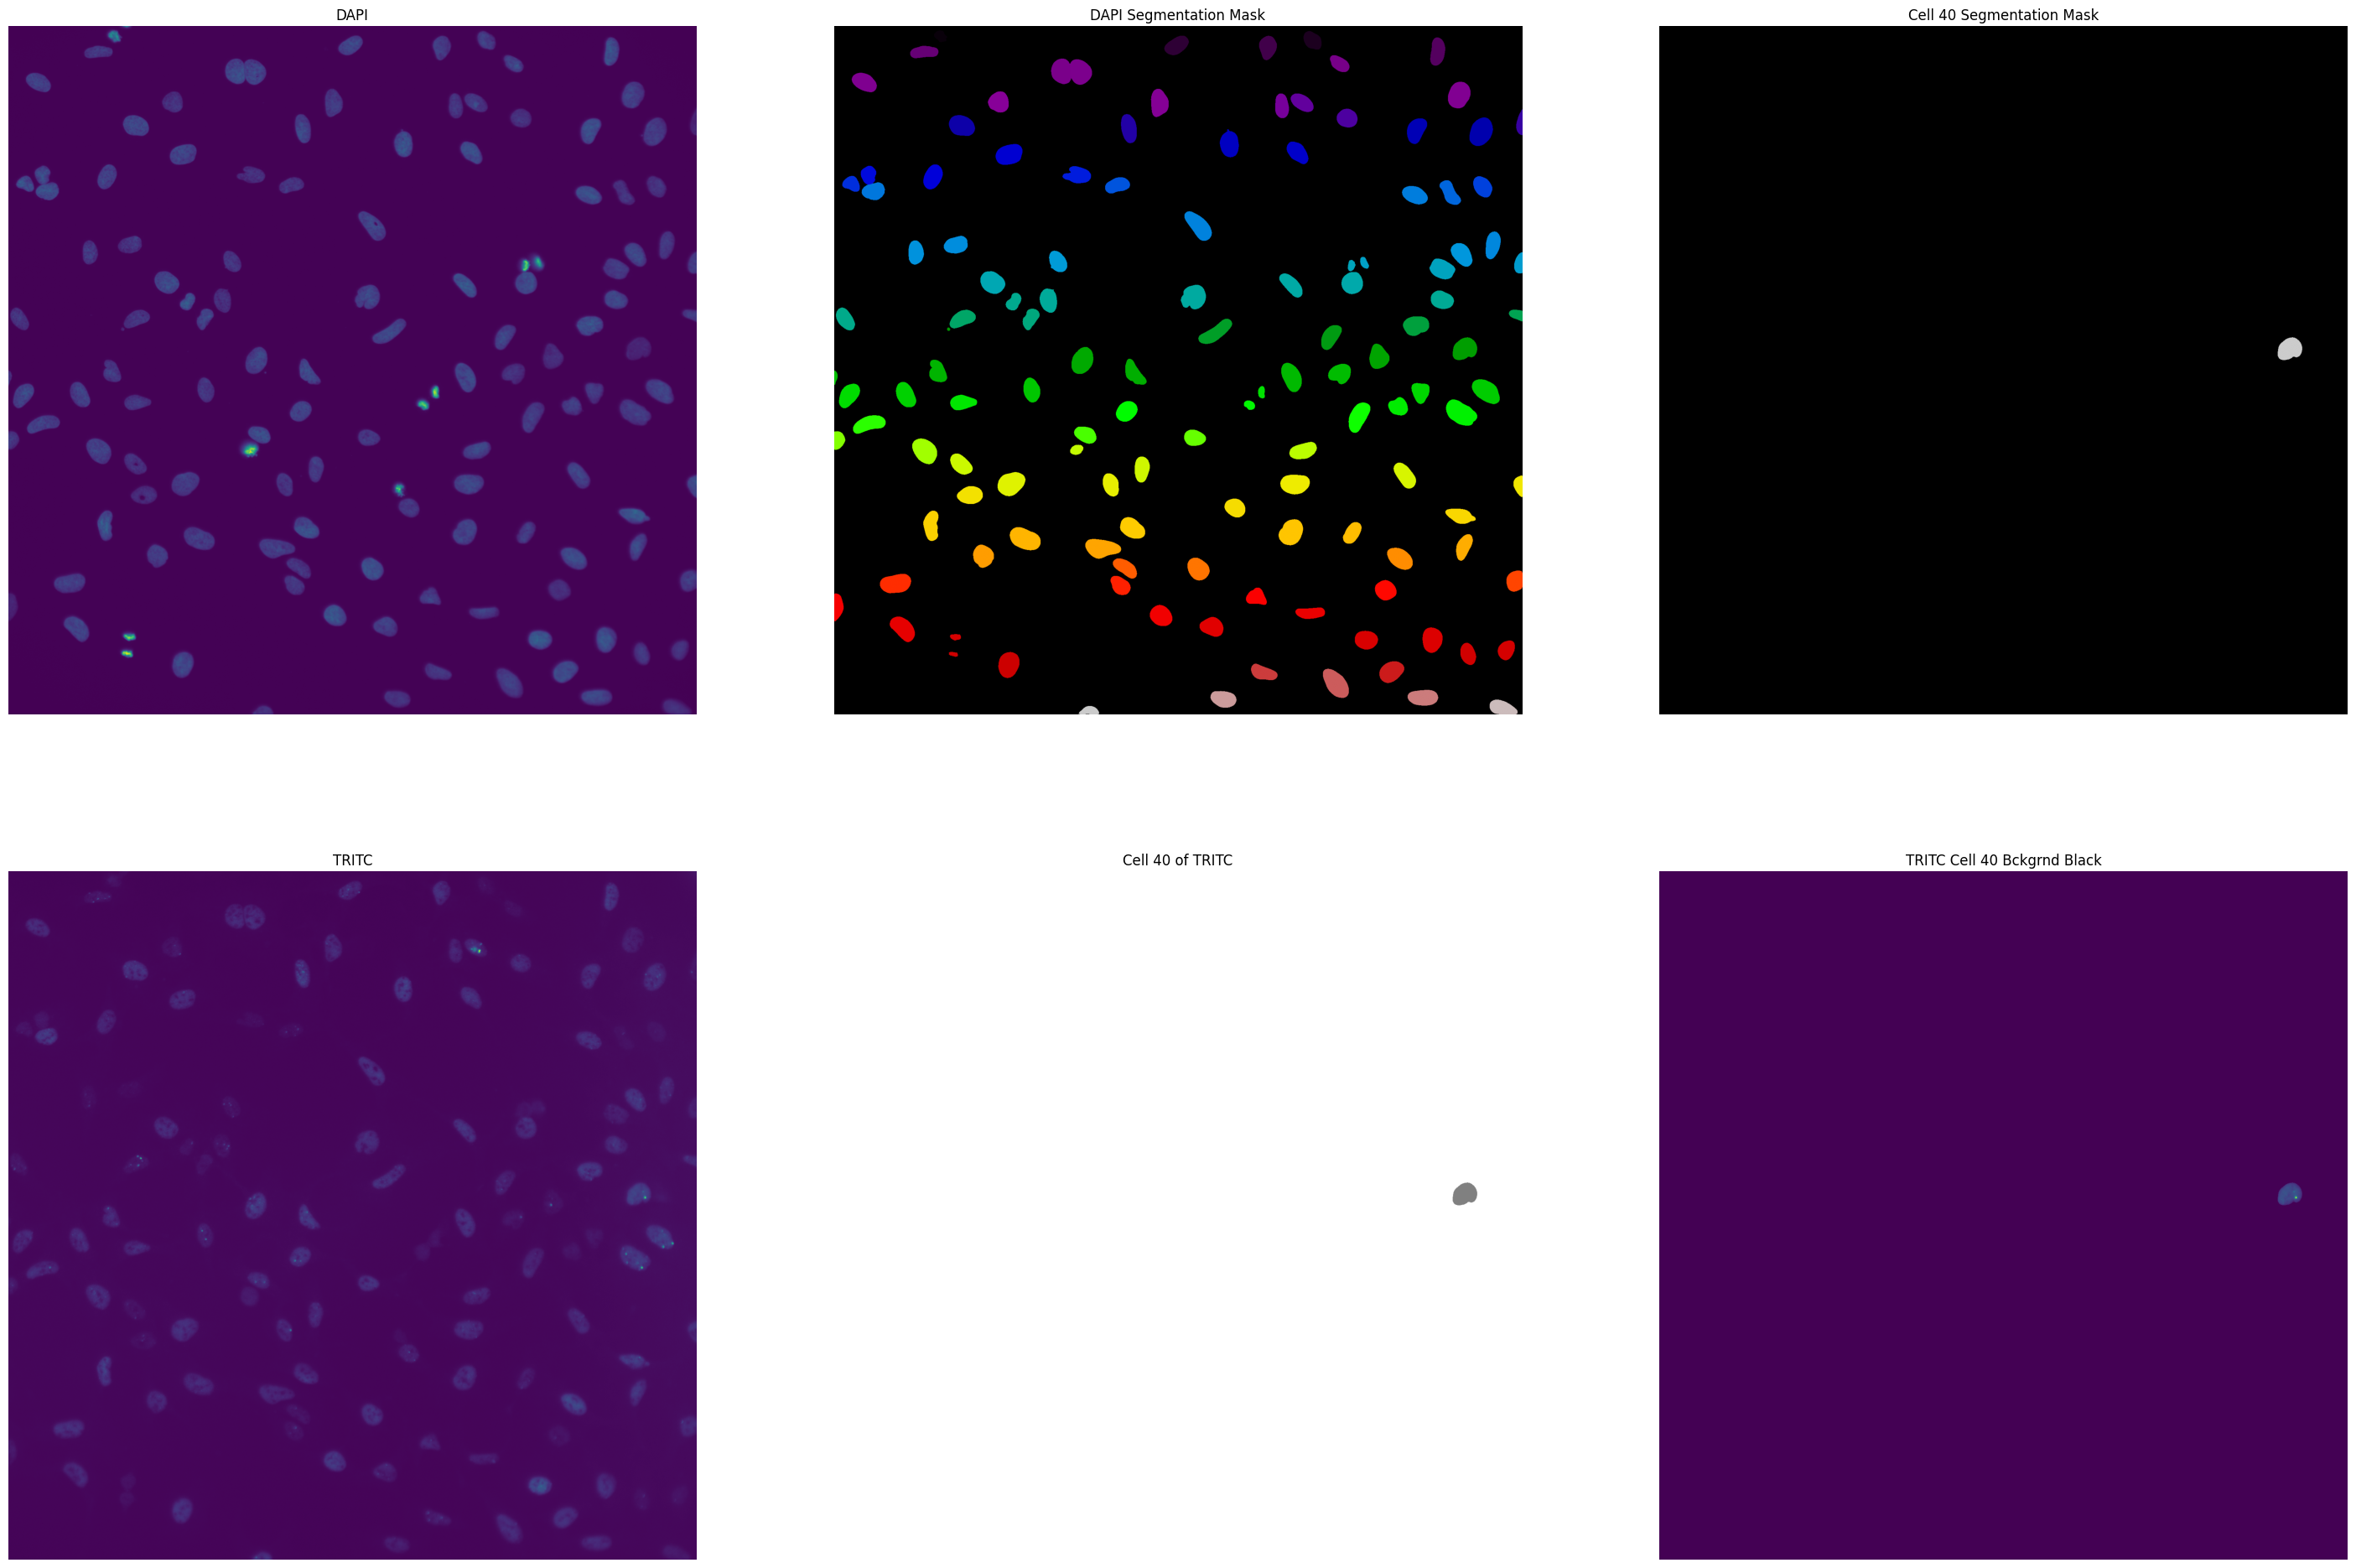

In [9]:
# Plotting Masks
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36, 24))

# Original DAPI Picture
axes[0,0].imshow(Test_DAPI)
axes[0,0].axis('off')
axes[0,0].set_title('DAPI')

# Full Segmentation Mask
axes[0,1].imshow(masks, cmap='nipy_spectral') 
axes[0,1].axis('off')
axes[0,1].set_title('DAPI Segmentation Mask')

# Singular Nucleus isolated from Mask
axes[0,2].imshow(masks_reduced, cmap='nipy_spectral')
axes[0,2].axis('off')
axes[0,2].set_title('Cell 40 Segmentation Mask')

# Original TRITC Picture
axes[1,0].imshow(Test_TRITC)
axes[1,0].axis('off')
axes[1,0].set_title('TRITC')

# Mask overlaying the TRITC Picture
axes[1,1].imshow(masked_TRITC, cmap='nipy_spectral', alpha=0.5)
axes[1,1].axis('off')
axes[1,1].set_title('Cell 40 of TRITC')

#show TRITC with applied mask
axes[1,2].imshow(isolated_TRITC)
axes[1,2].axis('off')
axes[1,2].set_title('TRITC Cell 40 Bckgrnd Black')

plt.show()